In [1]:
import os
import sys
PROJECT_PATH = os.path.abspath('..')
sys.path.append(PROJECT_PATH)

import pandas as pd
import pickle
Q = 0.25
P = 0.5

In [2]:
import numpy as np
from collections import defaultdict


class From_Jason_File:
    '''
    a wrapper for data read from chatgpt jason
    '''
    def __init__(self, nest_list_data) -> None:
        
        # dtype as np.int64 corresponds to pandas df wrds 
        self.dates = [np.int64(e['Date'].replace('-', '')) for e in nest_list_data]
        
        self.affected_companies = [e['Affected Companies'] for e in nest_list_data]
        self._process()
        
    def _process(self):
        total_companies =  [company for daily_afftected in self.affected_companies for company in list(daily_afftected.keys())]
        self.total_companies = list(set(total_companies))
        num_dates = len(self.dates)
        relation = []
        for i in range(num_dates):
            tem = defaultdict(lambda: [])
            for company,flag in self.affected_companies[i].items():
                tem[flag].append(company)
            relation.append(tem)
            
        
        self.relation = relation

    def __len__(self):
        return len(self.dates)
    
    def get_graphs(self,  relation_type = "positive"):
        return [x[relation_type] for x in self.relation]
    
    def get_graph_data(self, date_idx=0, date = None, relation_type = "positive"):
        if date is not None:
            print(date)
        else:
            return self.relation[date_idx][relation_type]

In [3]:
import json
with open(PROJECT_PATH + "/data/ticker_train_data.json") as json_file:
    ticker_train_data = json.load(json_file)
json_wrapper_train = From_Jason_File(ticker_train_data)

In [4]:
positive_rel = json_wrapper_train.get_graphs()
n = len(positive_rel)
print(n)

from src.data_process import stock_time_series 

TICKERS = ['HD', 'INTC', 'JPM', 'CAT', 'WMT', 'HON', 'JNJ', 'AXP', 'DIS', 'UNH', 'CVX', 'PG', 'NKE', 'IBM', 'CRM', 'AMGN', 'KO', 'BA', 'CSCO', 'TRV', 'AAPL', 'MSFT', 'DOW', 'MRK', 'MMM', 'WBA', 'V', 'GS', 'MCD', 'VZ']

TICKERS_IND = { ticker:i for i,ticker in enumerate(TICKERS)}
price = stock_time_series.get_stock_price(TICKERS,PROJECT_PATH + "/data" )
price = price.squeeze()
n, m = price.shape

stock_feature = stock_time_series.get_stock_feature(TICKERS,PROJECT_PATH + "/data")[:n]

273


/home/sam/mingsong/ChatgptGraph/static_graph_embedding/src/data_process/stock_time_series.py:52: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  wrds = pd.read_csv(path_to_csv)
/home/sam/mingsong/ChatgptGraph/static_graph_embedding/src/data_process/stock_time_series.py:76: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  wrds = pd.read_csv(path_to_csv)


In [5]:
our_format_per_day = [ [TICKERS_IND[ticker] for ticker in x] for x in json_wrapper_train.get_graphs()]

day_sep = 30
edges = []
A = [ [0 for j in range(30) ] for i in range(30)]
for _ in range(day_sep):
    for i in our_format_per_day[_]:
        for j in our_format_per_day[_]:
            if A[i][j] or A[j][i] or i==j:
                continue
            else:
                A[i][j] = 1
                edges.append([i,j])
                edges.append([j,i])
print(len(edges))

248


In [6]:
import networkx as nx
def read_graph(our_format):
	'''
	Reads the input network in networkx.
	'''
	if len(our_format)==2:
		lines = [str(x[0])+' '+str(x[1]) for x in zip(*our_format)]
	else:
		lines = [str(x[0])+' '+str(x[1]) for x in our_format]
	G = nx.parse_edgelist(lines, nodetype=int)
	for edge in G.edges():
		G[edge[0]][edge[1]]['weight'] = 1
	G = G.to_undirected()

	return G

In [7]:
import networkx as nx 
G = read_graph(edges)
pos = nx.spring_layout(G, center=[0.5, 0.5])
nx.set_node_attributes(G, pos, 'pos')

In [13]:
from torch_geometric.nn import Node2Vec
import torch
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.datasets import Planetoid
from tqdm.notebook import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
edges_tensor = torch.Tensor(list(zip(*edges))).to(dtype=torch.long)
model = Node2Vec(edges_tensor, embedding_dim=128, 
                 walk_length=20,                        # lenght of rw
                 context_size=10, walks_per_node=20,
                 num_negative_samples=1, 
                 p=P, q=Q,                             # bias parameters
                 sparse=True).to(device)


In [15]:
loader = model.loader(batch_size=8, shuffle=True, num_workers=4)
for idx, (pos_rw, neg_rw) in enumerate(loader):
    print(idx, pos_rw.shape, neg_rw.shape)

0 torch.Size([1760, 10]) torch.Size([1760, 10])
1 torch.Size([1760, 10]) torch.Size([1760, 10])
2 torch.Size([1760, 10]) torch.Size([1760, 10])
3 torch.Size([1320, 10]) torch.Size([1320, 10])


In [16]:
import networkx as nx
edge_tuples = [tuple(x) for x in edges]
G = nx.from_edgelist(edge_tuples)
pos = nx.spring_layout(G, center=[0.5, 0.5])
nx.set_node_attributes(G, pos, 'pos')

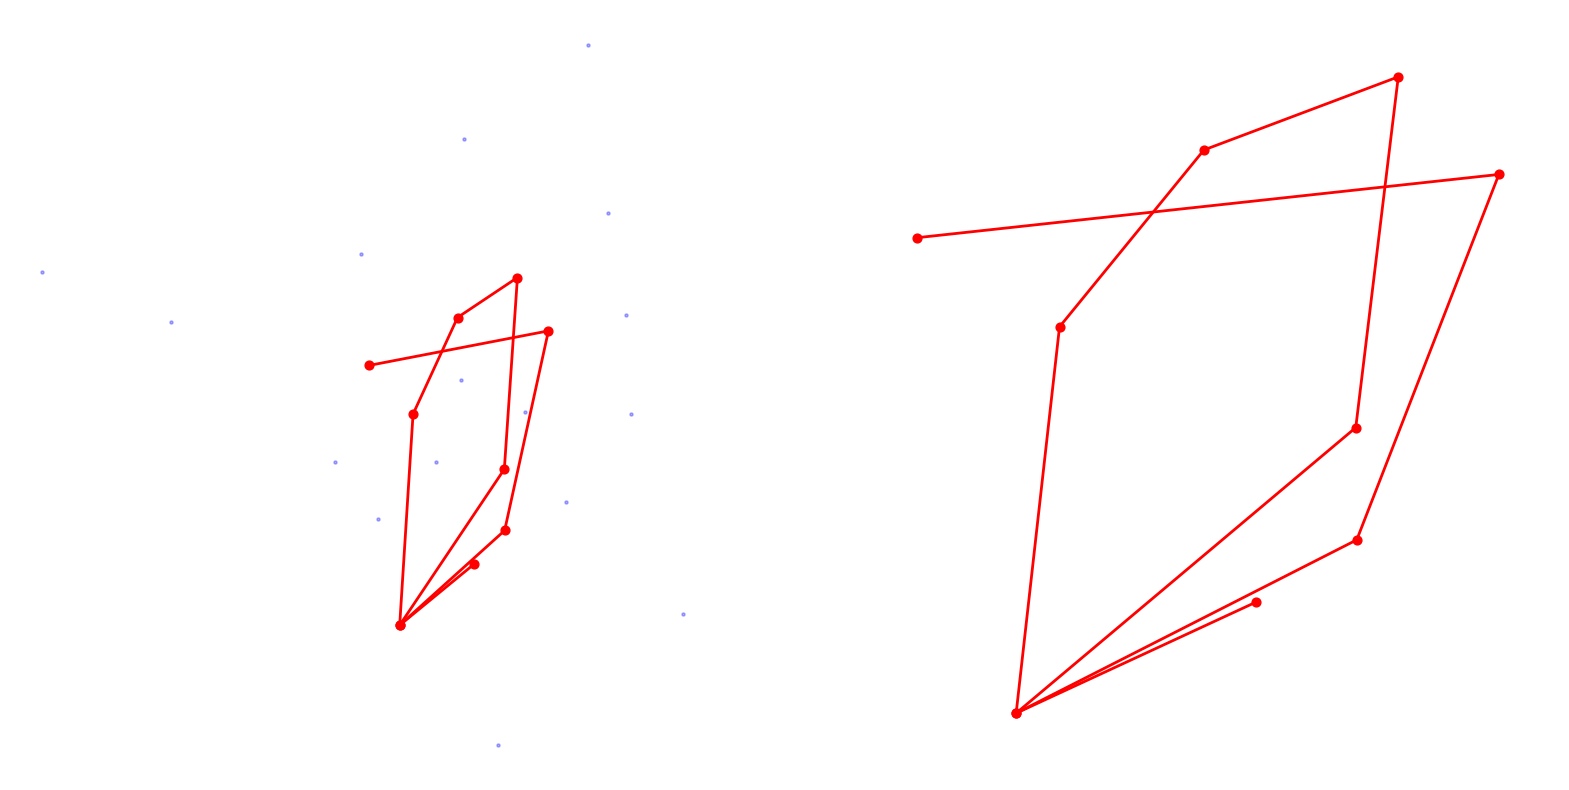

In [17]:
nodelist = next(enumerate(loader))[1][0][0].tolist()
walk = nx.path_graph(len(nodelist))
nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx_nodes(G,
                       ax=ax,
                       pos=nx.get_node_attributes(G, 'pos'),
                       node_size=5,
                       alpha=0.3,
                       node_color='b')
nx.draw(walk,
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'),
        width=2,
        edge_color='r')
ax = fig.add_subplot(1, 2, 2)
nx.draw(walk,
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'),
        width=2,
        edge_color='r')

In [18]:
model = Node2Vec(edges_tensor, embedding_dim=128, walk_length=20,
                 context_size=10, walks_per_node=10,
                 num_negative_samples=1, p=1, q=1, sparse=True).to(device)

loader = model.loader(batch_size=8, shuffle=True, num_workers=4)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

In [19]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in tqdm(loader):
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [21]:
model()

torch.Size([30, 128])

In [32]:
dist = np.mean((price[30:60]/price[29]-1)>0,axis=1)
dist

array([0.33333333, 0.36666667, 0.43333333, 0.26666667, 0.3       ,
       0.3       , 0.4       , 0.36666667, 0.13333333, 0.03333333,
       0.03333333, 0.03333333, 0.03333333, 0.1       , 0.2       ,
       0.13333333, 0.3       , 0.23333333, 0.5       , 0.6       ,
       0.63333333, 0.56666667, 0.7       , 0.66666667, 0.7       ,
       0.63333333, 0.63333333, 0.6       , 0.63333333, 0.63333333])

In [38]:
less = np.mean((price[30:60]/price[29]-1)>0,axis=1)>=0.25
greater = np.mean((price[30:60]/price[29]-1)>0,axis=1)>=0.6
ret = 1*greater + 1*less
ret = torch.tensor(ret,dtype=torch.long,device=device)

In [39]:
@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(z, ret,
                     z, ret,
                     max_iter=150)
    return acc

In [40]:
for epoch in range(1, 50):
    loss = train()
    acc = test()
    print(f'Epoch: {epoch:02d}, Loss: {loss:.4f}, Acc: {acc:.4f}')

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 01, Loss: 10.3245, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 02, Loss: 9.1221, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 03, Loss: 7.7546, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 04, Loss: 6.9855, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 05, Loss: 6.3066, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 06, Loss: 5.6266, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 07, Loss: 5.3446, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 08, Loss: 5.1237, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 09, Loss: 4.9033, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 10, Loss: 4.7819, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 11, Loss: 4.6587, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 12, Loss: 4.6443, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 13, Loss: 4.5130, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 14, Loss: 4.3559, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 15, Loss: 4.4620, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 16, Loss: 4.4882, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 17, Loss: 4.3633, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 18, Loss: 4.3989, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 19, Loss: 4.4177, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 20, Loss: 4.3795, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 21, Loss: 4.4297, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 22, Loss: 4.4881, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 23, Loss: 4.4371, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 24, Loss: 4.3386, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 25, Loss: 4.4373, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 26, Loss: 4.4818, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 27, Loss: 4.3066, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 28, Loss: 4.2961, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 29, Loss: 4.3970, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 30, Loss: 4.4581, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 31, Loss: 4.2420, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 32, Loss: 4.3656, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 33, Loss: 4.4831, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 34, Loss: 4.3430, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 35, Loss: 4.4892, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 36, Loss: 4.4559, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 37, Loss: 4.3381, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 38, Loss: 4.2607, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 39, Loss: 4.3784, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 40, Loss: 4.3921, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 41, Loss: 4.1401, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 42, Loss: 4.3758, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 43, Loss: 4.3199, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 44, Loss: 4.3444, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 45, Loss: 4.3262, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 46, Loss: 4.4903, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 47, Loss: 4.4620, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 48, Loss: 4.4323, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 49, Loss: 4.4657, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 50, Loss: 4.3013, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 51, Loss: 4.4735, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 52, Loss: 4.4547, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 53, Loss: 4.5151, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 54, Loss: 4.4021, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 55, Loss: 4.4622, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 56, Loss: 4.4388, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 57, Loss: 4.3994, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 58, Loss: 4.5326, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 59, Loss: 4.2665, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 60, Loss: 4.2603, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 61, Loss: 4.4478, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 62, Loss: 4.3386, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 63, Loss: 4.3523, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 64, Loss: 4.3551, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 65, Loss: 4.3745, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 66, Loss: 4.2903, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 67, Loss: 4.3534, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 68, Loss: 4.2950, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 69, Loss: 4.5132, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 70, Loss: 4.3470, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 71, Loss: 4.4973, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 72, Loss: 4.3531, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 73, Loss: 4.5138, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 74, Loss: 4.3072, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 75, Loss: 4.3751, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 76, Loss: 4.3127, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 77, Loss: 4.2648, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 78, Loss: 4.4547, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 79, Loss: 4.4075, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 80, Loss: 4.4128, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 81, Loss: 4.4874, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 82, Loss: 4.3543, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 83, Loss: 4.3797, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 84, Loss: 4.3659, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 85, Loss: 4.3763, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 86, Loss: 4.4574, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 87, Loss: 4.2427, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 88, Loss: 4.3917, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 89, Loss: 4.3758, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 90, Loss: 4.4054, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 91, Loss: 4.4944, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 92, Loss: 4.3423, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 93, Loss: 4.3675, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 94, Loss: 4.3788, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 95, Loss: 4.4272, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 96, Loss: 4.4422, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 97, Loss: 4.4054, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 98, Loss: 4.3240, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 99, Loss: 4.3718, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 100, Loss: 4.4235, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 101, Loss: 4.3370, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 102, Loss: 4.3367, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 103, Loss: 4.3923, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 104, Loss: 4.3587, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 105, Loss: 4.2938, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 106, Loss: 4.5030, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 107, Loss: 4.3391, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 108, Loss: 4.2782, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 109, Loss: 4.2948, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 110, Loss: 4.3895, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 111, Loss: 4.4222, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 112, Loss: 4.3774, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 113, Loss: 4.5442, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 114, Loss: 4.3187, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 115, Loss: 4.4671, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 116, Loss: 4.4754, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 117, Loss: 4.3439, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 118, Loss: 4.4142, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 119, Loss: 4.2016, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 120, Loss: 4.3512, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 121, Loss: 4.3380, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 122, Loss: 4.1712, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 123, Loss: 4.1208, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 124, Loss: 4.3097, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 125, Loss: 4.4225, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 126, Loss: 4.4000, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 127, Loss: 4.3513, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 128, Loss: 4.4005, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 129, Loss: 4.3449, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 130, Loss: 4.3316, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 131, Loss: 4.2672, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 132, Loss: 4.2918, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 133, Loss: 4.1401, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 134, Loss: 4.2437, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 135, Loss: 4.3793, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 136, Loss: 4.1589, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 137, Loss: 4.2429, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 138, Loss: 4.2953, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 139, Loss: 4.3702, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 140, Loss: 4.2336, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 141, Loss: 4.3104, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 142, Loss: 4.3209, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 143, Loss: 4.2111, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 144, Loss: 4.2029, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 145, Loss: 4.1750, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 146, Loss: 4.2825, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 147, Loss: 4.3026, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 148, Loss: 4.2304, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 149, Loss: 4.2281, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 150, Loss: 4.1792, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 151, Loss: 4.3645, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 152, Loss: 4.3411, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 153, Loss: 4.2522, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 154, Loss: 4.3295, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 155, Loss: 4.1944, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 156, Loss: 4.1669, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 157, Loss: 4.3686, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 158, Loss: 4.3253, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 159, Loss: 4.3300, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 160, Loss: 4.1853, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 161, Loss: 4.2958, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 162, Loss: 4.2168, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 163, Loss: 4.2386, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 164, Loss: 4.2640, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 165, Loss: 4.3314, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 166, Loss: 4.2733, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 167, Loss: 4.3484, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 168, Loss: 4.2752, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 169, Loss: 4.2728, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 170, Loss: 4.3467, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 171, Loss: 4.2988, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 172, Loss: 4.3069, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 173, Loss: 4.3545, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 174, Loss: 4.2992, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 175, Loss: 4.3325, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 176, Loss: 4.3653, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 177, Loss: 4.3080, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 178, Loss: 4.3605, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 179, Loss: 4.1806, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 180, Loss: 4.3906, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 181, Loss: 4.3290, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 182, Loss: 4.2790, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 183, Loss: 4.3246, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 184, Loss: 4.2385, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 185, Loss: 4.3692, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 186, Loss: 4.1813, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 187, Loss: 4.2716, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 188, Loss: 4.2472, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 189, Loss: 4.2461, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 190, Loss: 4.3459, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 191, Loss: 4.3980, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 192, Loss: 4.3538, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 193, Loss: 4.2894, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 194, Loss: 4.3178, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 195, Loss: 4.3484, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 196, Loss: 4.3654, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 197, Loss: 4.2252, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 198, Loss: 4.2360, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 199, Loss: 4.3365, Acc: 1.0000


  0%|          | 0/4 [00:00<?, ?it/s]

Epoch: 200, Loss: 4.2518, Acc: 1.0000


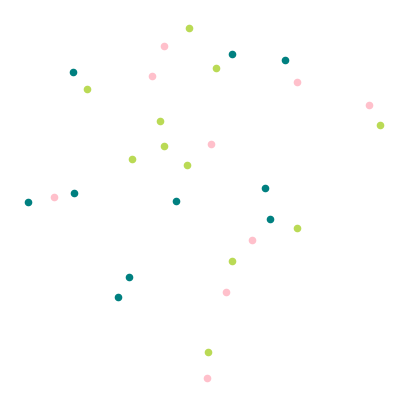

In [50]:
@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model(torch.arange(30, device=device))
    z = TSNE(n_components=2,perplexity=5).fit_transform(z.cpu().numpy())
    y = ret.cpu().numpy()

    plt.figure(figsize=(5, 5))
    for i in range(3):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()

colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535',
    '#ffd700'
]
plot_points(colors)

In [ ]:
import networkx as nx
def read_graph(our_format):
	'''
	Reads the input network in networkx.
	'''
	if len(our_format)==2:
		lines = [str(x[0])+' '+str(x[1]) for x in zip(*our_format)]
	else:
		lines = [str(x[0])+' '+str(x[1]) for x in our_format]
	G = nx.parse_edgelist(lines, nodetype=int)
	for edge in G.edges():
		G[edge[0]][edge[1]]['weight'] = 1
	G = G.to_undirected()

	return G

In [7]:
import node2vector as node2vec
p = 0.25
q = 0.25
num_walks =5
walk_length = 5
nx_G = read_graph(edges)
G = node2vec.Graph(nx_G, p, q)
G.preprocess_transition_probs()
walks = G.simulate_walks(num_walks, walk_length)

Walk iteration:
1 / 5
2 / 5
3 / 5
4 / 5
5 / 5


In [8]:
nodelist = next(enumerate(loader))[1][0][0].tolist()
walk = nx.path_graph(len(nodelist))
nx.set_node_attributes(walk, {idx: pos[node_id] for idx, node_id in enumerate(nodelist)}, 'pos')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1, 2, 1)
nx.draw_networkx_nodes(G, 
                       ax=ax,
                       pos=nx.get_node_attributes(G, 'pos'), 
                       node_size=5,
                       alpha=0.3,
                       node_color='b')
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 
ax = fig.add_subplot(1, 2, 2)
nx.draw(walk, 
        node_size=40,
        node_color='r',
        ax=ax,
        pos=nx.get_node_attributes(walk, 'pos'), 
        width=2,
        edge_color='r') 

NameError: name 'loader' is not defined

In [11]:
edges

[[20, 4],
 [4, 20],
 [27, 21],
 [21, 27],
 [27, 4],
 [4, 27],
 [27, 14],
 [14, 27],
 [21, 4],
 [4, 21],
 [21, 14],
 [14, 21],
 [4, 14],
 [14, 4],
 [22, 17],
 [17, 22],
 [22, 2],
 [2, 22],
 [22, 27],
 [27, 22],
 [22, 1],
 [1, 22],
 [17, 2],
 [2, 17],
 [17, 27],
 [27, 17],
 [17, 1],
 [1, 17],
 [2, 27],
 [27, 2],
 [2, 1],
 [1, 2],
 [27, 1],
 [1, 27],
 [27, 16],
 [16, 27],
 [16, 21],
 [21, 16],
 [29, 23],
 [23, 29],
 [29, 6],
 [6, 29],
 [23, 6],
 [6, 23],
 [13, 23],
 [23, 13],
 [13, 21],
 [21, 13],
 [13, 28],
 [28, 13],
 [13, 14],
 [14, 13],
 [13, 4],
 [4, 13],
 [23, 21],
 [21, 23],
 [23, 28],
 [28, 23],
 [23, 14],
 [14, 23],
 [23, 4],
 [4, 23],
 [21, 28],
 [28, 21],
 [28, 14],
 [14, 28],
 [28, 4],
 [4, 28],
 [26, 4],
 [4, 26],
 [26, 8],
 [8, 26],
 [4, 8],
 [8, 4],
 [27, 28],
 [28, 27],
 [27, 13],
 [13, 27],
 [27, 12],
 [12, 27],
 [28, 12],
 [12, 28],
 [13, 12],
 [12, 13],
 [10, 27],
 [27, 10],
 [10, 4],
 [4, 10],
 [10, 23],
 [23, 10],
 [27, 23],
 [23, 27],
 [20, 28],
 [28, 20],
 [20, 23],